loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 17 matching image-depth map pairs.


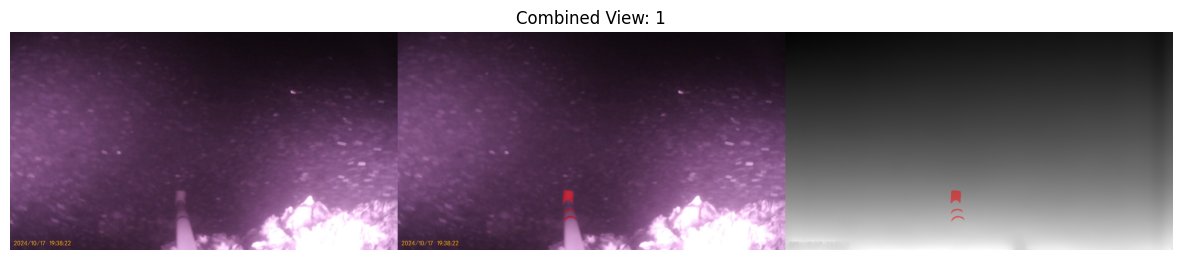

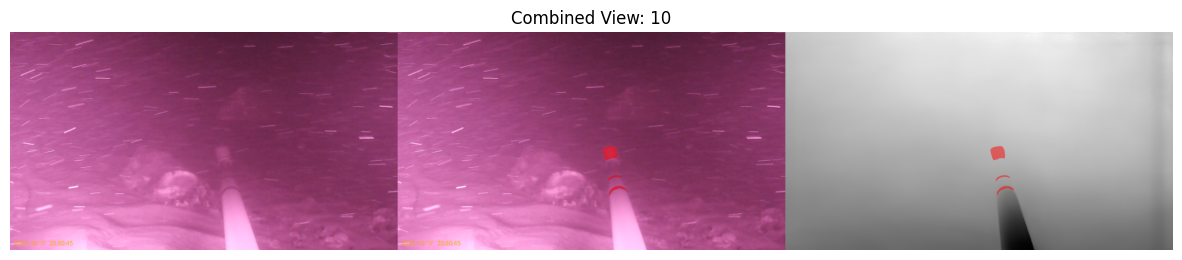

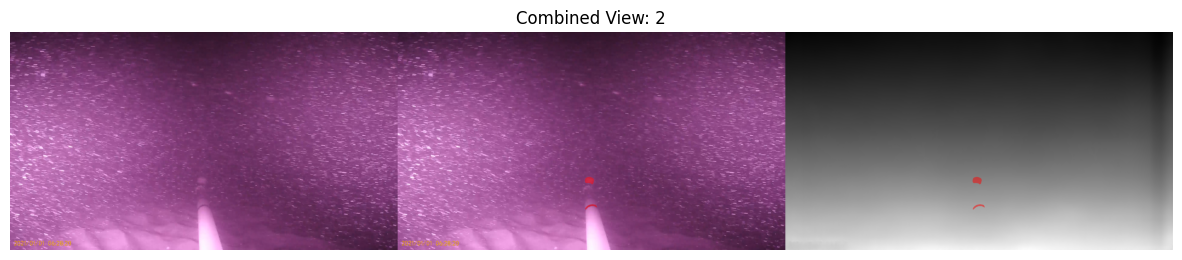

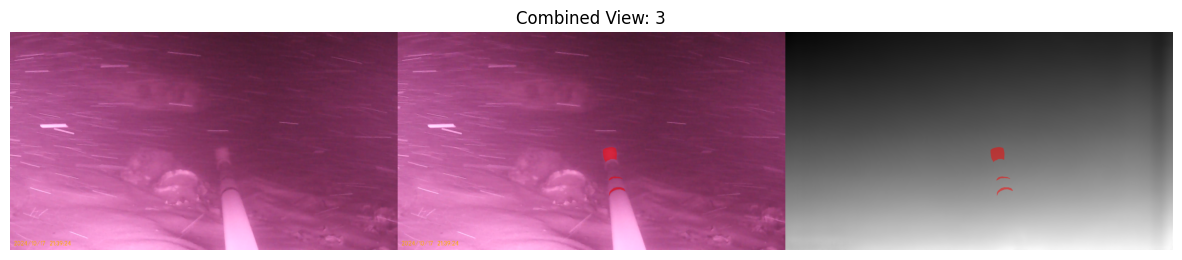

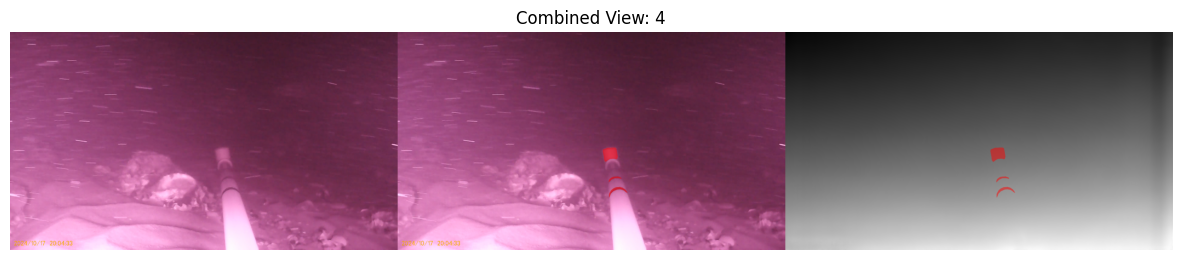

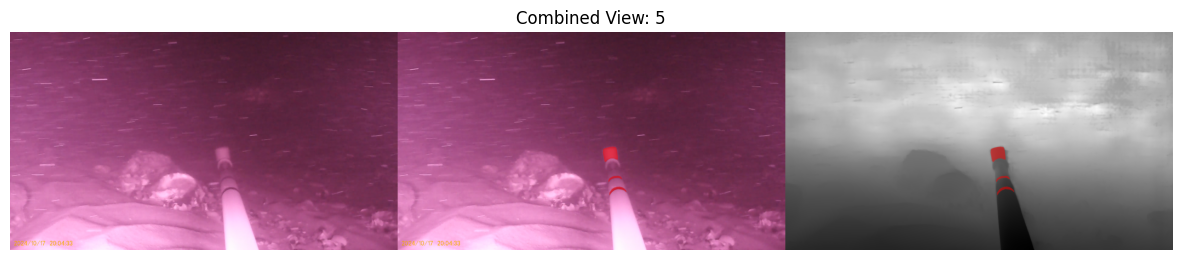

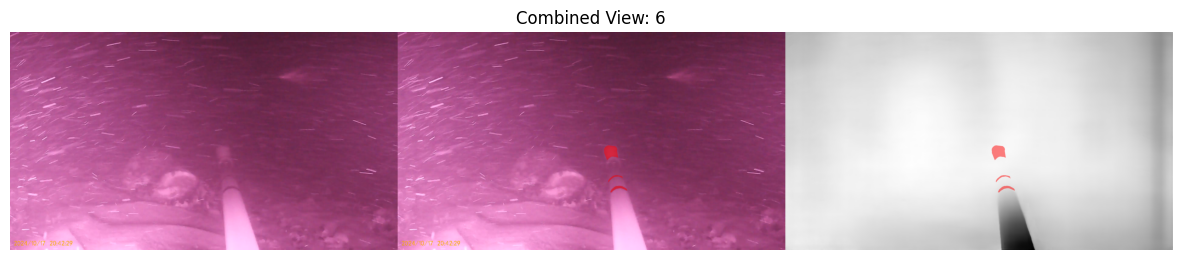

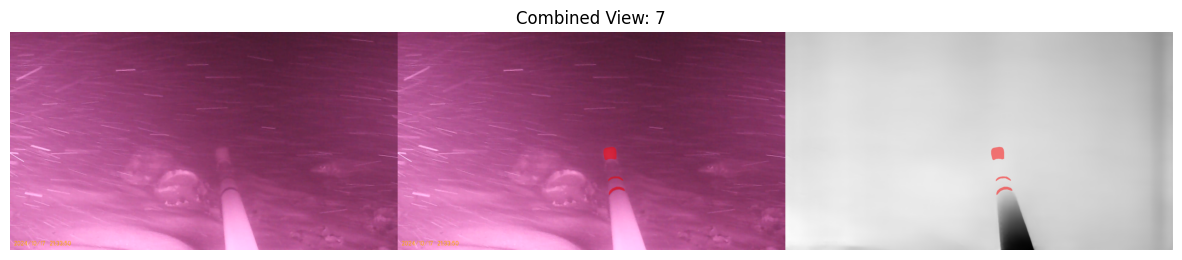

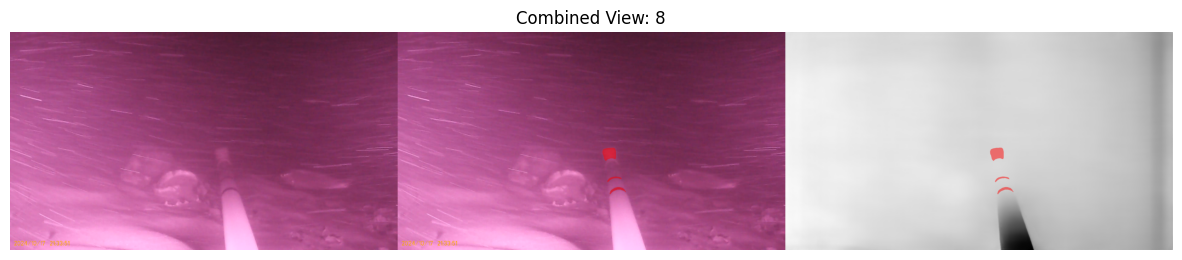

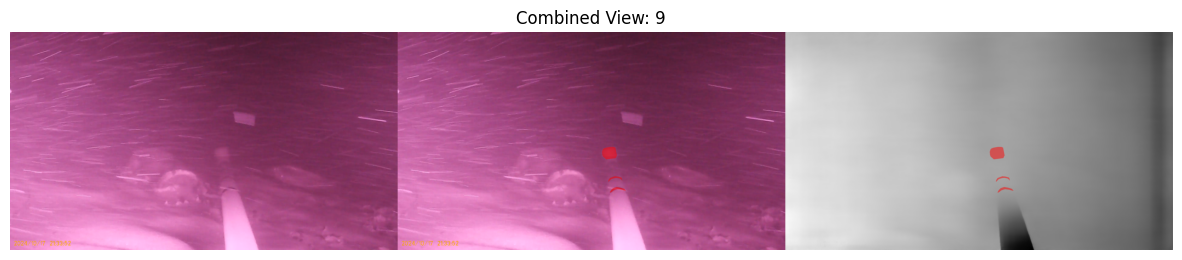

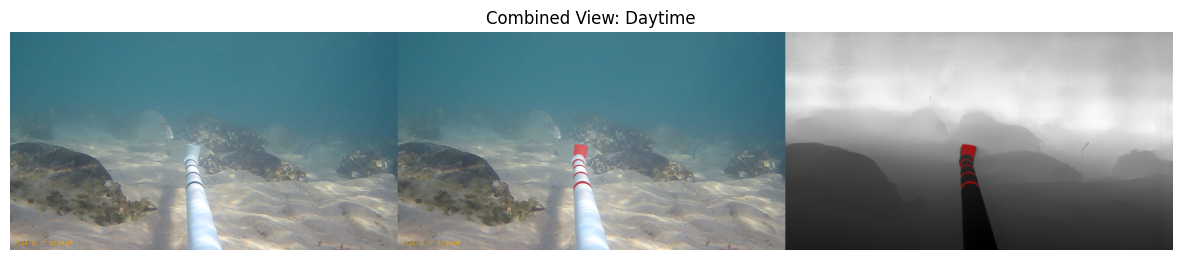

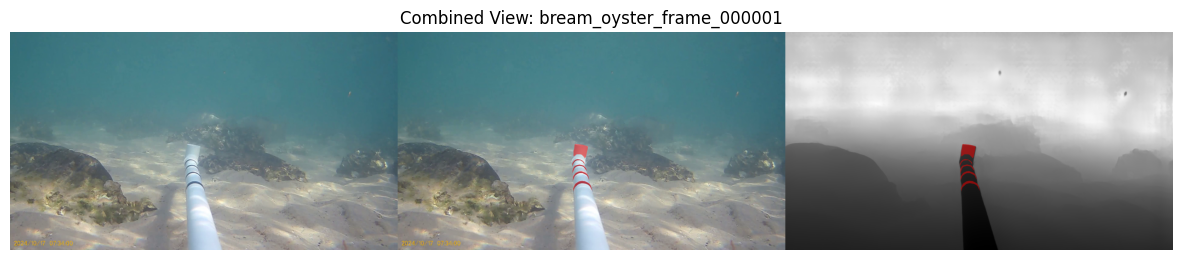

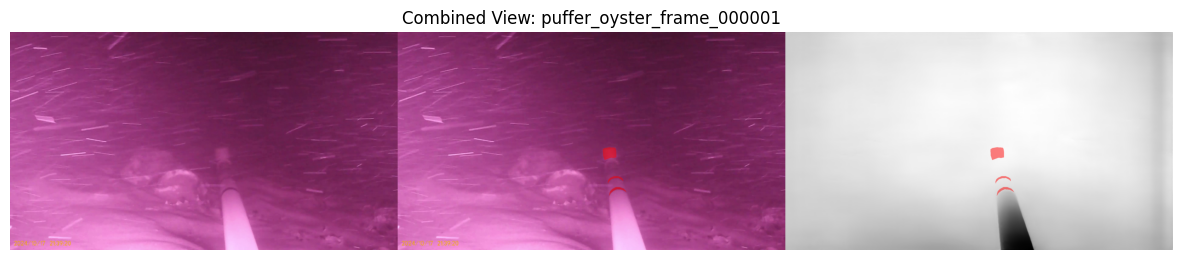

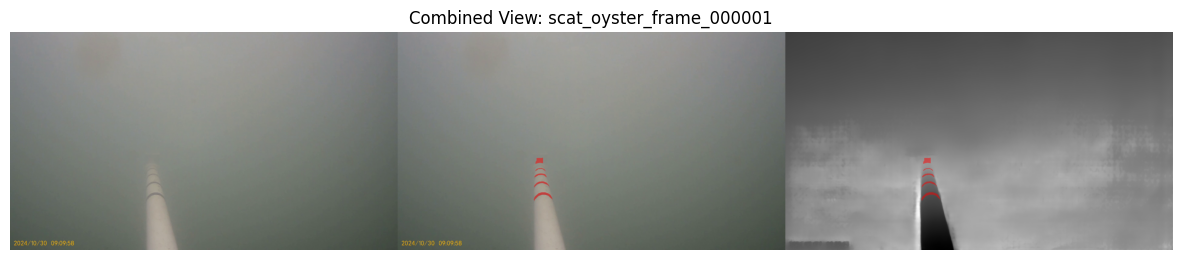

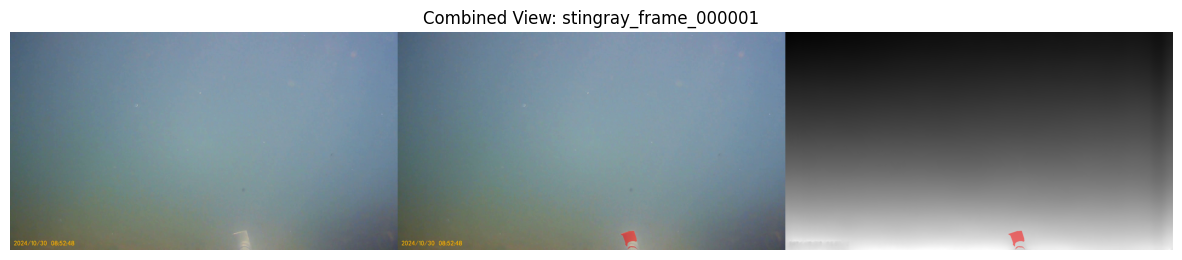

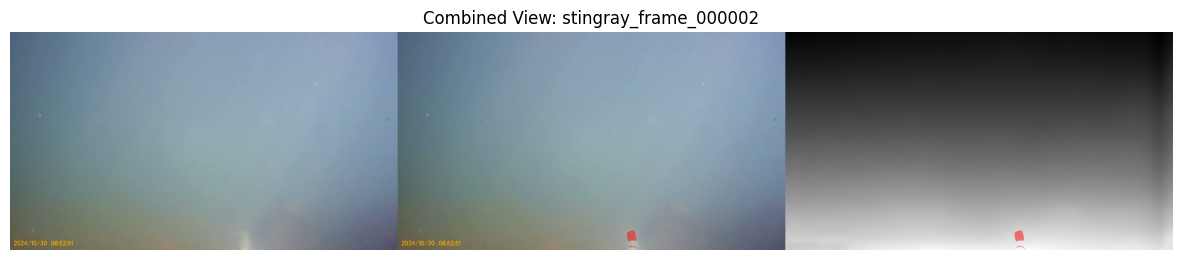

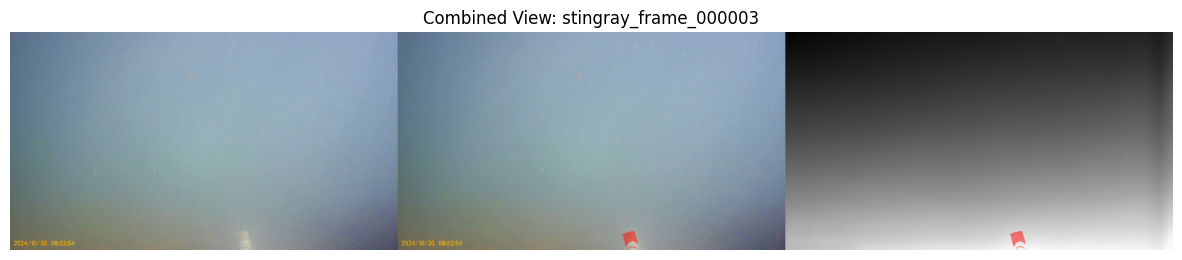

/tmp/ipykernel_31520/320015801.py:41: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(output_pdf_path) as pdf:


In [1]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Paths
image_directory = '../data/deigo/annotations/images/'  # Original images
depth_map_directory = '../data/deigo/depth-maps/annotate-frames-dmap/'  # Depth maps
json_file = '../data/deigo/annotations/annotations/instances_default.json'  # JSON annotations

# Output PDF path
output_pdf_path = './combined_images_v2.pdf'

# Load the COCO annotations
coco = COCO(json_file)

# Get all images and create a mapping of file names to image IDs
all_images = coco.loadImgs(coco.getImgIds())
file_name_to_id = {img['file_name']: img['id'] for img in all_images}

# Get all image files and corresponding depth map files
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg'))])
depth_map_files = sorted([f for f in os.listdir(depth_map_directory) if f.endswith(('_pred04.png'))])

# Ensure image and depth map filenames match
image_to_depth_map = {
    os.path.splitext(img)[0]: os.path.join(depth_map_directory, depth_map)
    for img in image_files
    for depth_map in depth_map_files
    if os.path.splitext(img)[0] in depth_map
}

if not image_to_depth_map:
    print("No matching images and depth maps found.")
else:
    print(f"Found {len(image_to_depth_map)} matching image-depth map pairs.")

# Initialize the PDF
with PdfPages(output_pdf_path) as pdf:
    # Process each image and corresponding depth map
    for image_filename, depth_map_path in image_to_depth_map.items():
        # Load the original image
        image_path = os.path.join(image_directory, image_filename + '.png')
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Original image not found at {image_path}. Skipping.")
            continue

        # Convert to RGB for visualization
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        target_height, target_width = original_image_rgb.shape[:2]

        # Load the depth map
        depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)
        if depth_map is None:
            print(f"Depth map not found at {depth_map_path}. Skipping.")
            continue

        # Normalize depth map for visualization
        if depth_map.dtype == np.uint8:
            depth_map_normalized = depth_map
        elif depth_map.dtype == np.uint16:
            depth_map_normalized = (depth_map / 65535.0 * 255).astype(np.uint8)
        else:
            depth_map_normalized = (depth_map * 255).astype(np.uint8)

        # Resize depth map to match the original image dimensions
        depth_map_resized = cv2.resize(depth_map_normalized, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

        # Convert depth map to RGB for segmentation overlay
        depth_map_rgb = cv2.cvtColor(depth_map_resized, cv2.COLOR_GRAY2RGB)

        # Get image ID using the file name to ID mapping
        image_id = file_name_to_id.get(image_filename + '.png')
        if image_id is None:
            print(f"No annotations found for {image_filename}. Skipping.")
            continue

        # Get annotations for the image
        ann_ids = coco.getAnnIds(imgIds=[image_id])
        annotations = coco.loadAnns(ann_ids)

        # Create a copy of the original image and depth map for segmentation overlay
        segmentation_overlay = original_image_rgb.copy()
        depth_map_with_mask = depth_map_rgb.copy()

        # Apply segmentation masks
        for ann in annotations:
            if 'segmentation' in ann:
                mask = coco.annToMask(ann)
                color = np.array([255, 0, 0])  # Red color
                # Overlay mask on original image
                segmentation_overlay[mask > 0] = (
                    segmentation_overlay[mask > 0] * 0.5 + color * 0.5
                ).astype(np.uint8)
                # Overlay mask on depth map
                depth_map_with_mask[mask > 0] = (
                    depth_map_with_mask[mask > 0] * 0.5 + color * 0.5
                ).astype(np.uint8)

        # Combine all three images into one
        combined_image = np.hstack((
            original_image_rgb,
            segmentation_overlay,
            depth_map_with_mask
        ))

        # Add the combined image to the PDF
        plt.figure(figsize=(15, 5))
        plt.imshow(combined_image)
        plt.axis('off')
        plt.title(f"Combined View: {image_filename}")
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to avoid overlapping

    print(f"All combined images have been saved to {output_pdf_path}")
